## Task Description
The goPuff Operations team needs to staff locations appropriately to efficiently fulfill orders and keep
our customers happy.
You are provided a subset of order data for some initial model building aimed at forecasting orders
for each of the next 14 days. The plan is to present this model to another data scientist on your
team and your manager. The main goal is to present your basic model and make recommendations
for future improvements. Your recommendations for future work could consider both increasing
model complexity and using additional data.

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
import itertools
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from fbprophet import Prophet
from matplotlib import pyplot

## Project walkthrough
1. Data Import
2. Descriptive Data Analysis
    - 2.1 Data quality(missing values & data types)
    - 2.2 Distribution of order counts
3. Model Building 
    - 3.1 San Francisco
    - 3.2 Santa Babara
    - 3.3 Los Angeles

4. Next step 

5. Appendix(Model selection process)

## Data Import

In [120]:
gopuff=pd.read_excel('orders_by_location.xlsx')

In [121]:
gopuff

,location_id,location_name,date,order_count
0,6,"San Francisco, CA",2018-01-01,8411
1,19,"Santa Barbara, CA",2018-01-01,265
2,6,"San Francisco, CA",2018-01-02,4886
3,19,"Santa Barbara, CA",2018-01-02,178
4,6,"San Francisco, CA",2018-01-03,4505
...,...,...,...,...
1293,6,"San Francisco, CA",2019-08-10,7934
1294,19,"Santa Barbara, CA",2019-08-10,263
1295,114,"Los Angeles, CA",2019-08-11,216
1296,6,"San Francisco, CA",2019-08-11,7468


In [122]:
## 1298 number of users
## All variable types seems correct 
gopuff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298 entries, 0 to 1297
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   location_id    1298 non-null   int64         
 1   location_name  1298 non-null   object        
 2   date           1298 non-null   datetime64[ns]
 3   order_count    1298 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 40.7+ KB


## Data processing & Descriptive Analysis 

In [123]:
## Check null values
gopuff.isnull().sum()

location_id      0
location_name    0
date             0
order_count      0
dtype: int64

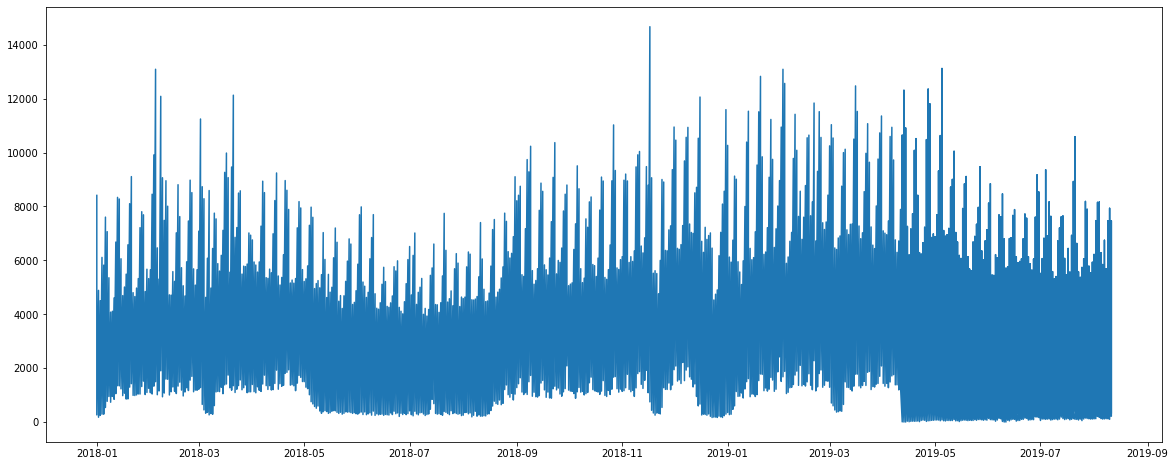

In [124]:
## plot the realtionship between 'date' and 'order count'
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(gopuff['date'],gopuff['order_count'])

Based on the plot, the change of order_count are not in an obvious pattern

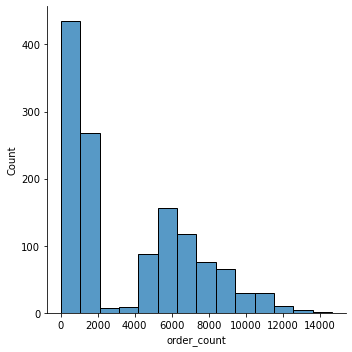

In [125]:
sns.displot(gopuff['order_count'])

The distribution of order counts is not normal. Many orders are concentrated less than 2000 per day.

In [126]:
gopuff['location_name'].value_counts()

San Francisco, CA    588
Santa Barbara, CA    588
Los Angeles, CA      122
Name: location_name, dtype: int64

In [127]:
pd.pivot_table(gopuff,index=['location_name','location_id'],values='order_count',aggfunc=[np.sum])

,,sum
,,order_count
location_name,location_id,
"Los Angeles, CA",114,10178
"San Francisco, CA",6,4150668
"Santa Barbara, CA",19,535621


In [128]:
pd.pivot_table(gopuff,index=['location_name','location_id'],values='order_count',aggfunc=[np.mean])

,,mean
,,order_count
location_name,location_id,
"Los Angeles, CA",114,83.426230
"San Francisco, CA",6,7058.959184
"Santa Barbara, CA",19,910.920068


One location_name refers to one location_id, 3 different locations have obvious different in value counts and mean order_counts. It is better for us to split the data into three subsets based on location difference

In [129]:
cities=pd.pivot_table(gopuff,index=['date'],columns=['location_name'],values='order_count')

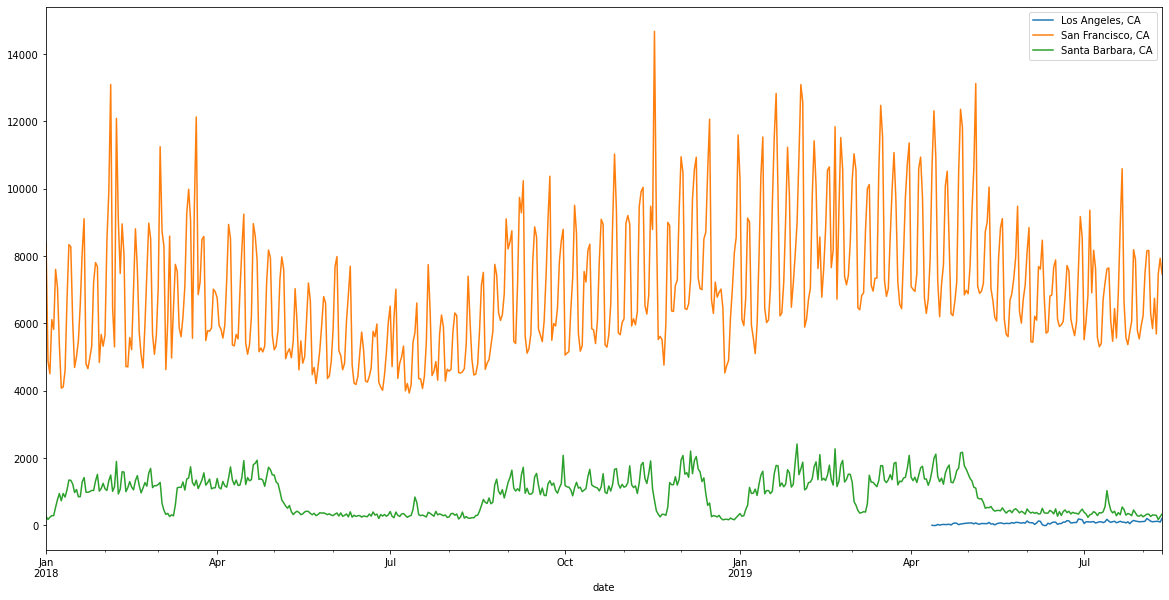

In [130]:
plt.rcParams["figure.figsize"] = (20,10)
cities.plot()
plt.legend()
plt.show()

From the graphs, the patterns of 3 different locations totally different, thus we are going to predict them based on 3 different Time Series models

## San Francisco, CA


In [131]:
SF=gopuff[gopuff['location_name']=='San Francisco, CA'].drop(['location_id','location_name'],axis=1).set_index('date')
SF

,order_count
date,
2018-01-01,8411
2018-01-02,4886
2018-01-03,4505
2018-01-04,6110
2018-01-05,5823
...,...
2019-08-07,6747
2019-08-08,5688
2019-08-09,7474


Text(0.5, 1.0, 'San Francisco orders')

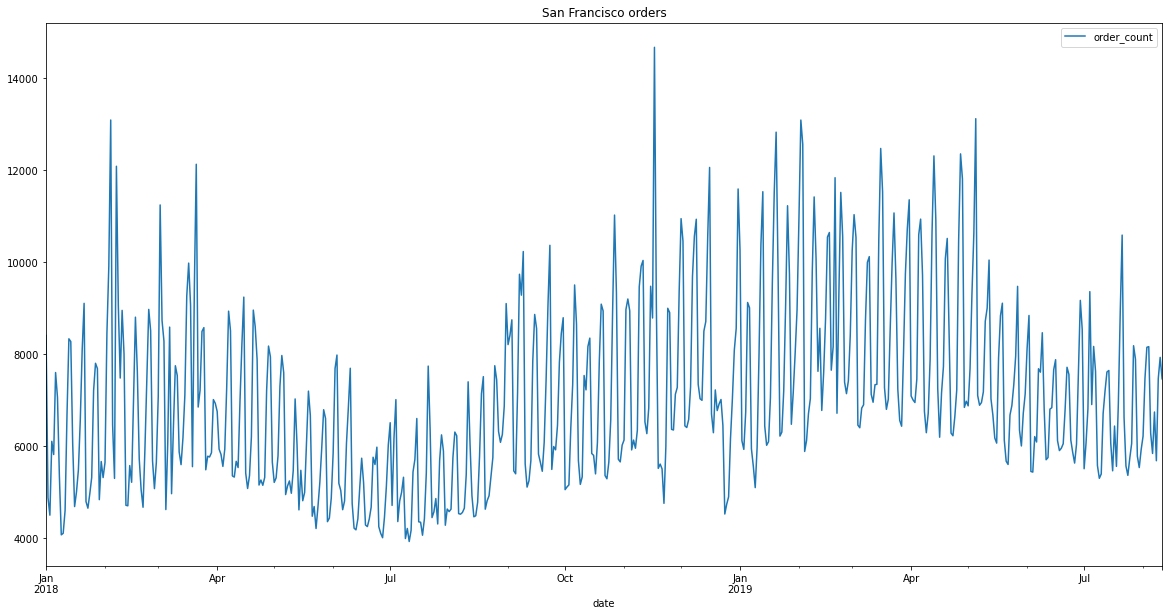

In [132]:
SF.plot()
plt.title("San Francisco orders")

1. It is a up-ward tendency
2. It has obvious seasonality pattern
3. the variances doesn't keep constant

### Check time series stationarity

In [135]:
def rolling(dataset):
    rolmean=dataset.rolling(window=7,center=False).mean()
    rolstd=dataset.rolling(window=7,center=False).std()
    fig=plt.figure(figsize=(12,6))
    org=plt.plot(dataset,color='blue',label='orginal')
    mean=plt.plot(rolmean,color='red',label='7 days rolling mean')
    std=plt.plot(rolstd,color='black',label='7 days rolling std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

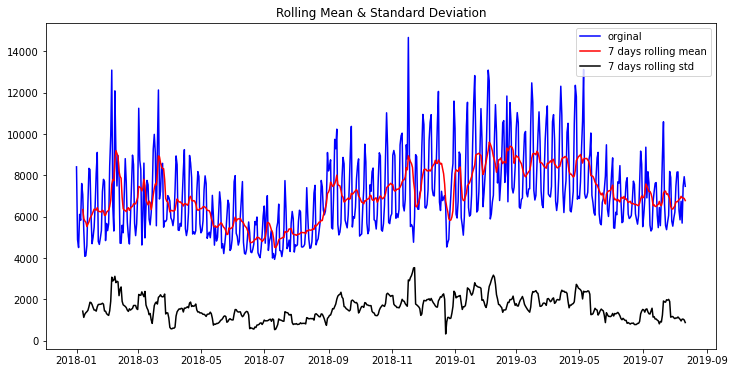

In [136]:
rolling(SF)

 The variance doesnot seems increase over time 

## FB Prophet

Facebook developed an open sourcing Prophet, a forecasting tool available in both Python and R. It provides intuitive parameters which are easy to tune. Even someone who lacks deep expertise in time-series forecasting models can use this to generate meaningful predictions for a variety of problems in business scenarios.


The Prophet uses a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

y(t)= g(t) + s(t) + h(t) + εt
- g(t): piecewise linear or logistic growth curve for modeling non-periodic changes in time series
- s(t): periodic changes (e.g. weekly/yearly seasonality)
- h(t): effects of holidays (user provided) with irregular schedules
- εt: error term accounts for any unusual changes not accommodated by the model

It has lower MAE than ARIMA model so I choose this as my model

## Prediction

In [139]:
## The package requires columns to be ds and y
SF=SF.reset_index()
SF.columns=['ds','y']

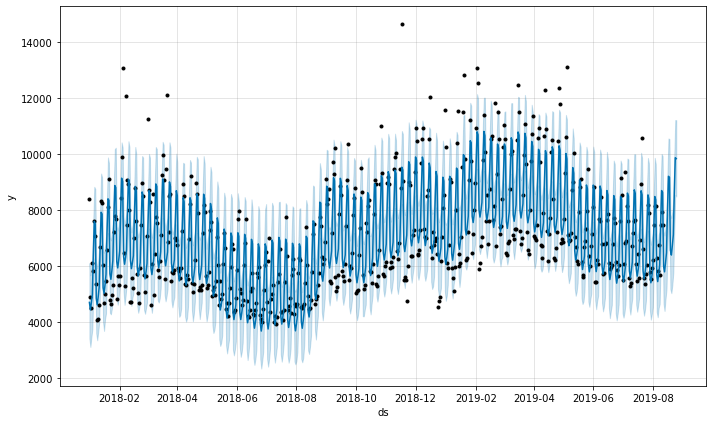

In [158]:
# define the model
m1=Prophet(growth='linear',
          changepoint_prior_scale=0.1,
          holidays_prior_scale=0.3,
          changepoint_range=0.9,
          yearly_seasonality=True,
          weekly_seasonality=True,
          seasonality_prior_scale=0.2,
          daily_seasonality=False)
m1.fit(SF)
future1=m1.make_future_dataframe(periods=14)
forecast1=m1.predict(future1)
fig=m1.plot(forecast1)

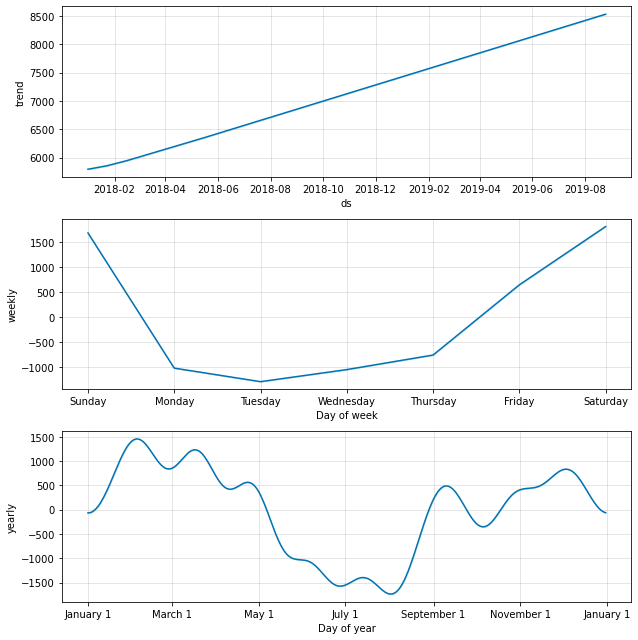

In [159]:
m1.plot_components(forecast1);

- The trend is upward.
- The day of week effect shows that more orders on weekends, less orders in weekdays(Except on Friday, orders increased sharply)
- The day of year effect shows that from January to July the order count are decreasing and reaches the bottom on July but it goes up from July to the new year.

In [148]:
forecast_14days=forecast[-14:][['ds','yhat']]

In [149]:
forecast_14days.to_csv('SF Prediction')

## Santa Barbara, CA

In [151]:
SB=gopuff[gopuff['location_name']=='Santa Barbara, CA'].drop(['location_id','location_name'],axis=1).set_index('date')

Text(0.5, 1.0, 'Santa Barbara')

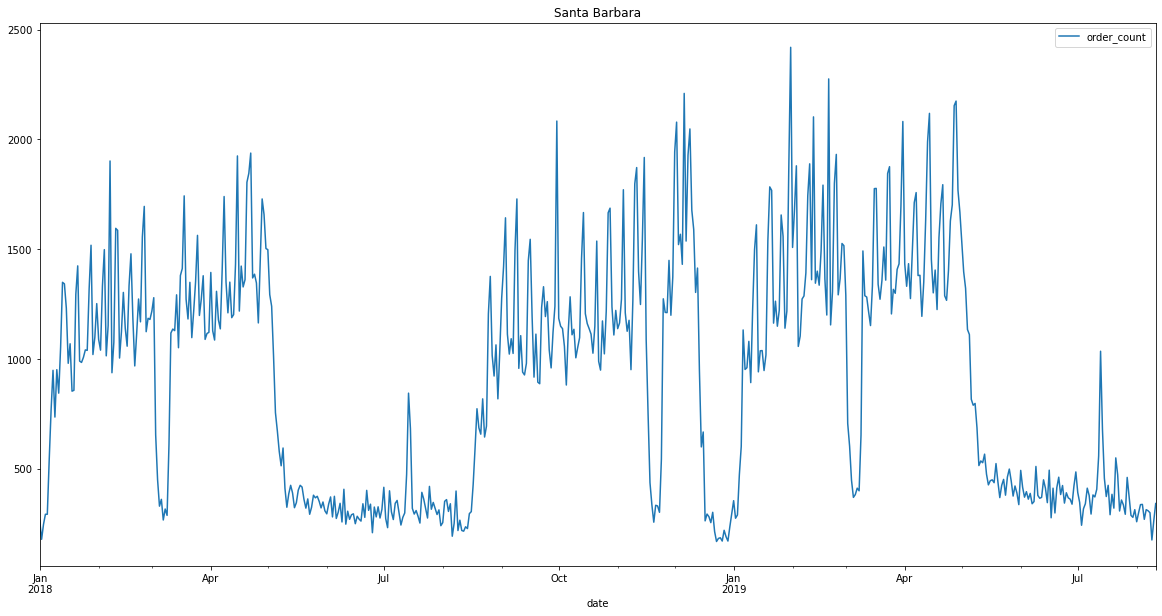

In [152]:
SB.plot()
plt.title("Santa Barbara")

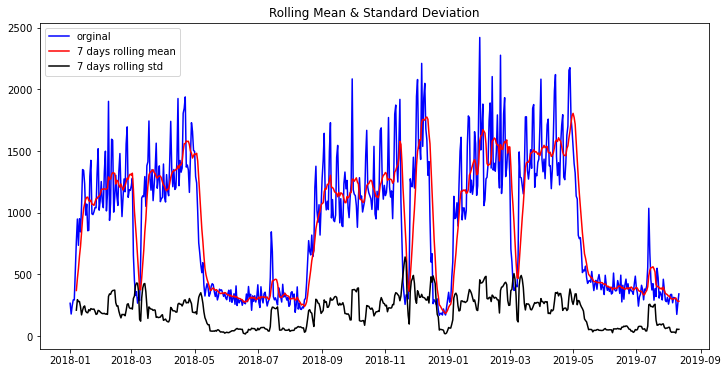

In [154]:
rolling(SB)

In [155]:
SB=SB.reset_index()
SB.columns=['ds','y']

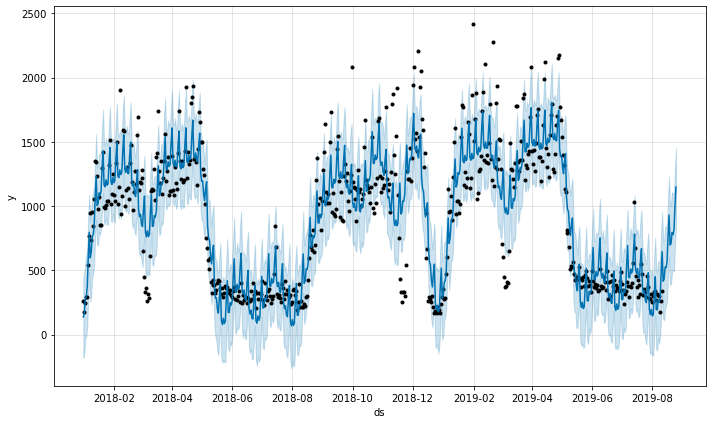

In [160]:
# define the model
m2=Prophet(growth='linear',
          changepoint_prior_scale=0.1,
          holidays_prior_scale=0.3,
          changepoint_range=0.9,
          yearly_seasonality=True,
          weekly_seasonality=True,
          seasonality_prior_scale=0.2,
          daily_seasonality=False)
m2.fit(SB)
future2=m2.make_future_dataframe(periods=14)
forecast2=m2.predict(future2)
fig=m2.plot(forecast2)

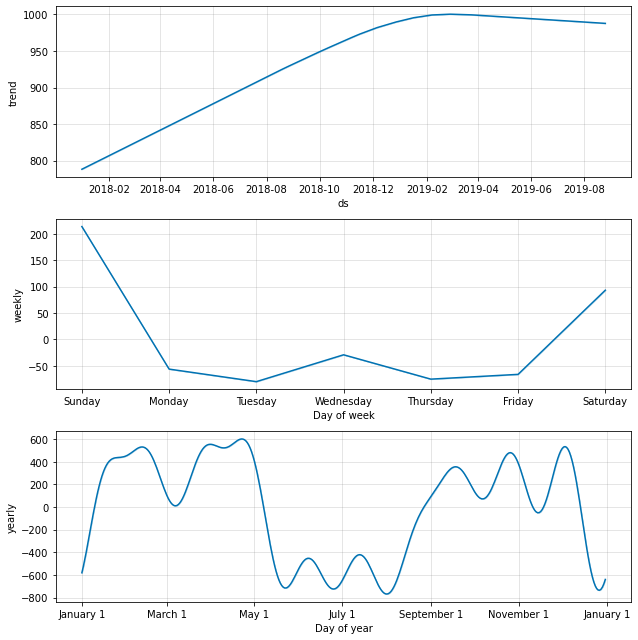

In [162]:
m2.plot_components(forecast2);

- The trend is upward but reaches the top around Feb 2019 and then decreases.
- The day of week effect shows that more orders on weekends, much less orders in weekdays.
- The day of year effect shows that in January the order rises quicky and reached to high level of orders until may, but  reaches the bottom on June and July. After September, but it goes up until the end of the year

In [161]:
SB_14days=forecast2[-14:][['ds','yhat']]
SB_14days.to_csv('SB Prediction')

## Los Angeles

In [163]:
LA=gopuff[gopuff['location_name']=='Los Angeles, CA'].drop(['location_id','location_name'],axis=1).set_index('date')
LA

,order_count
date,
2019-04-12,6
2019-04-13,0
2019-04-14,0
2019-04-15,32
2019-04-16,11
...,...
2019-08-07,117
2019-08-08,124
2019-08-09,122


Text(0.5, 1.0, 'Los Angeles, CA ')

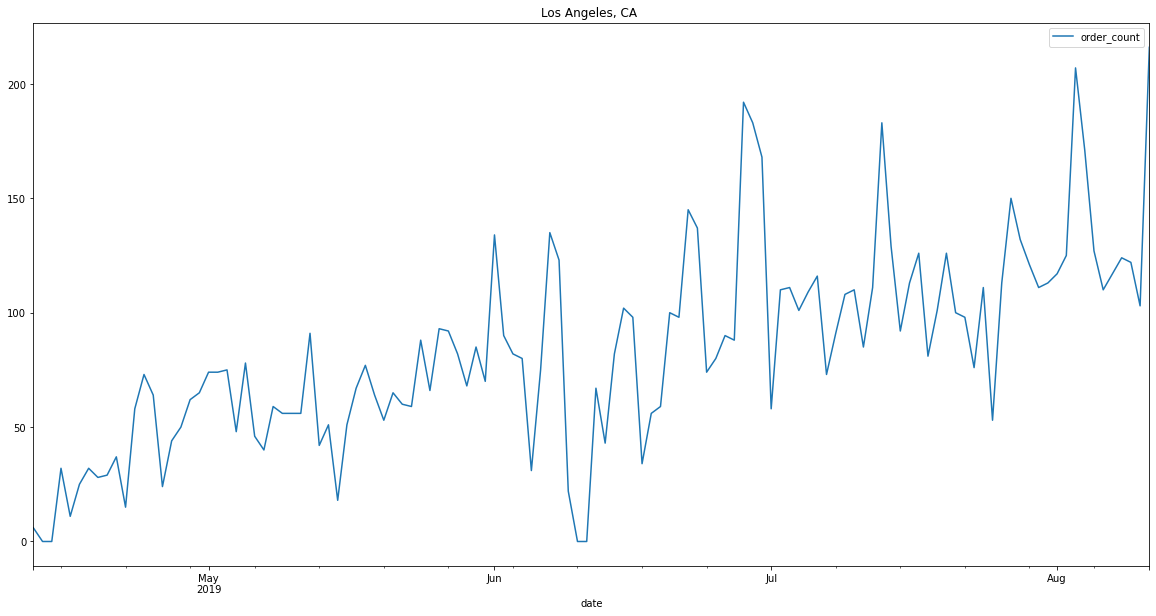

In [164]:
LA.plot()
plt.title("Los Angeles, CA ")

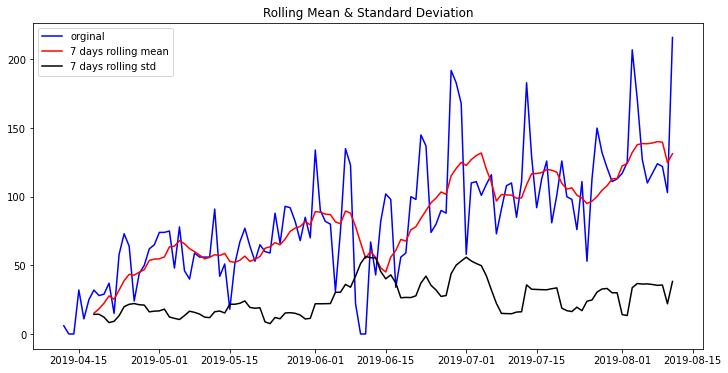

In [166]:
rolling(LA)

In [167]:
LA=LA.reset_index()
LA.columns=['ds','y']

In [169]:
LA

,ds,y
0,2019-04-12,6
1,2019-04-13,0
2,2019-04-14,0
3,2019-04-15,32
4,2019-04-16,11
...,...,...
117,2019-08-07,117
118,2019-08-08,124
119,2019-08-09,122
120,2019-08-10,103


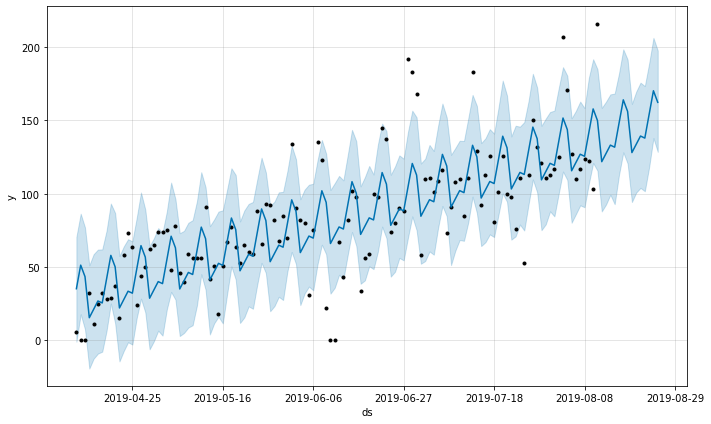

In [170]:
# define the model
m3=Prophet(growth='linear',
          changepoint_prior_scale=0.1,
          holidays_prior_scale=0.3,
          changepoint_range=0.9,
          yearly_seasonality=False,
          weekly_seasonality=True,
          seasonality_prior_scale=0.2,
          daily_seasonality=False)
m3.fit(LA)
future3=m3.make_future_dataframe(periods=14)
forecast3=m3.predict(future3)
fig=m3.plot(forecast3)

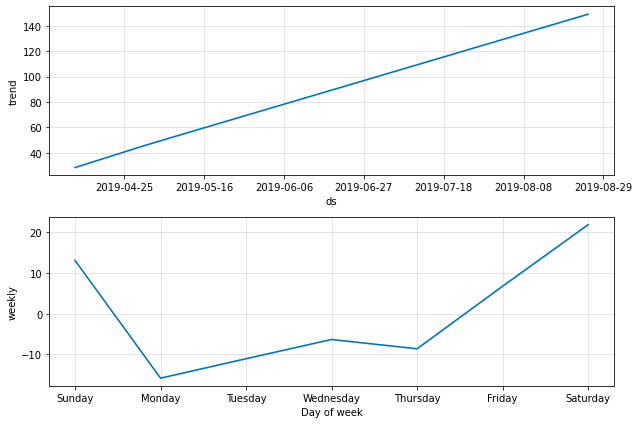

In [172]:
m3.plot_components(forecast3);

The trend is upward.
The day of week effect shows that from Monday the orders are mainting low but gradually increasing. Until Friday, the orders increase sharply 

In [171]:
LA_14days=forecast3[-14:][['ds','yhat']].round()
LA_14days.to_csv('LA Prediction')

## Summary & Next step
1. Main Finding
    - Different locations have different ordering numbers' developing patterns. We should treat it separately
    - The time series of orders in different locations have tendency effects, weekly effects, seasonality effects, and yearly effects. We could use the FB prophet model to separate those effects and apply them to predictions. It has better performance than the ARIMA model.
    
2. Different insights for differnt locations:
    - San Francisco 
        - The trend is upward.
        - The day of week effect shows that more orders on weekends, less orders in weekdays(Except on Friday, orders increased sharply)
        - The day of year effect shows that from January to July the order count are decreasing and reaches the bottom on July but it goes up from July to the new year.
    - Santa Babara
       - The trend is upward but reaches the top around Feb 2019 and then decreases.
       - The day of week effect shows that more orders on weekends, much less orders in weekdays.
       - The day of year effect shows that in January the order rises quicky and reached to high level of orders until may, but reaches the bottom on June and July. After September, but it goes up until the end of the year.
    - Los Angeles
        - The trend is upward. 
        - The day of week effect shows that from Monday the orders are mainting low but gradually increasing. Until Friday, the orders increase sharply.


** I used two methods to compare, one is the ARIMA time series model, the other one is the FBProphet model. Splitting datasets into train and test datasets (80%-20%), I trained the model and tested it with test data. The performance evaluation of models is based on mean absolute errors. Based on the metrics, I used the FB prophet model for the predictions.


3. Recommendations
    - (1) Time series model
    
        - For the time series model, more data over a longer time is better for training and fitting the models. Besides, the business team can provide some notations from holiday effects so that Data scientists can tune the model better.
    
    - (2) Deep dive in Time Series
    
        - For the seasonal, weekly, yearly effects, the Data scientist can deep dive into the business operation and customers profiles to figure out the reason and size of more opportunities for developing more orders.
    
    - (3) Attention to Santa Barbara
    
        - Its tendency is decreasing, which is needed more attention to promoting sales. For example, launch some marketing campaigns or more promotional activities.
    
    - (4) Develop more advanced models
    
        - To improve the predictions, more relevant variables should be provided. For example, the industry, the market and competitors' information, the customers' profiles, the marketing campaigns, and customers' lifetime values. From more information, Data Scientists can build up more models on predictions. For example, tree-based models, regressions models, and even deep learning.



## Apendix
### Attempts in ARIMA model
ARIMA stands for Auto Regressive Integrated Moving Average. ARIMA is a simple stochastic time series model that we can use to train and then forecast future time points. ARIMA can capture complex relationships as it takes error terms and observations of lagged terms.

** Here I show the code for reference.

In [ ]:
#Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller
#Run test
result = adfuller(SF['order_count'])
#Print test statistic
print('ADF Statistic:',result[0])
#Print p-value
print('p-value:',result[1])
#Print critical values
print(result[4])

 Accept the null hypothesis that the time series is not sationary

In [ ]:
### First difference

In [ ]:
#Calculate the first difference of the time series
sf_stationary = SF.diff().dropna()

#Run ADF test on the differenced time series
result0 = adfuller(sf_stationary['order_count'])

#Plot the differenced time series
fig, ax = plt.subplots()
sf_stationary.plot(ax=ax)
plt.show()

#Print the test statistic and the p-value
print('ADF Statistic:', result0[0])
print('p-value:', result0[1])

p-value is way lower than 0.05, which shows that we can reject the null hypothesis. The first difference of sf is stationary.

In [ ]:
#Calculate log-return and drop nans
sf_log = np.log(SF)
sf_log = sf_log.dropna()

#Run test and print
result_log = adfuller(sf_log['order_count'])
print('ADF Statistic:', result_log[0])
print('p-value:', result_log[1])
##The ADF value for first difference is way more negative so it is better to use First difference

In [ ]:
##AR model
yt=a* y(t-1)+ε(t)
yt=a1* y(t-1) + a2* y(t-2)...+aq* y(t-q)  +ε(t)
##MA model
yt=m1* ε(t-1) + ε(t)
yt=m1* ε(t-1) + m2* ε(t-2)...+mq* ε(t-q)  +ε(t)
##ARMA model -p ,-q
-p the order of AR part
-q the order of MA part

In [ ]:
def acf_pacf(dataset):
    fig,ax=plt.subplots(figsize=(8,3))
    plot_acf(dataset,ax=ax,lags=40)
    fig,ax=plt.subplots(figsize=(8,3))
    plot_pacf(dataset,ax=ax,lags=40)

In [ ]:
acf_pacf(sf_stationary)

In [ ]:
model=auto_arima(sf_train,trace=True,
                error_action='ignore',
                suppress_warning=True)
model.fit(sf_train)

In [ ]:
sf_forecast=model.predict(n_periods=len(sf_test))
sf_forecast=pd.DataFrame(sf_forecast,index=sf_test.index,columns=['order_counts'])

In [ ]:
def prediction(train,test,forecast):
    plt.plot(train,label='Train')
    plt.plot(test,label='test')
    plt.plot(forecast,label='Prediction')
    plt.xlabel('time')
    plt.ylabel('actual order count')
    plt.legend()
    plt.show()

In [ ]:
prediction(sf_train,sf_test,sf_forecast)

In [ ]:
print(mean_absolute_percentage_error(sf_forecast['order_counts'],sf_test['y']))

### Train & Test splits
For the use of comparing the model's performance

In [ ]:
#Split the data into a train and test set
sf_train = SF.loc[:'2019-04-10']
sf_test = SF.loc['2019-04-11':]

#Create an axis
fig, ax = plt.subplots()

#Plot the train and test sets on the axis ax
sf_train.plot(ax=ax)
sf_test.plot(ax=ax)
plt.show()

In [ ]:
sf_train

In [ ]:
sf_train=sf_train.reset_index()

In [ ]:
sf_train=sf_train.reset_index()
sf_train.columns=['ds','y']

In [ ]:
## define the model
m=Prophet(growth='linear',
          changepoint_prior_scale=0.1,
          holidays_prior_scale=0.1,
          changepoint_range=0.8,
          yearly_seasonality=True,
          weekly_seasonality=True,
          seasonality_prior_scale=0.1,
          daily_seasonality=False)
m.fit(sf_train)
future=m.make_future_dataframe(periods=122)
forecast=m.predict(future)
fig=m.plot(forecast)

In [ ]:
m.plot_components(forecast);

In [ ]:
forecast_new=forecast[-122:][['ds','yhat']]

In [ ]:
sf_test=sf_test.reset_index()
sf_test.columns=['ds','y']

In [ ]:
forecast_new=pd.merge(forecast_new,sf_test,on='ds',how='left')

In [ ]:
forecast_new['yhat']=forecast_new['yhat'].round()

In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

print(mean_absolute_percentage_error(forecast_new['y'],forecast_new['yhat']))